<a href="https://colab.research.google.com/github/sofiarochinhauab/convolutional-network/blob/main/convolutionalnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of roads as clean or littered
### Sofia Rocha
### Jorge Machado

# Imports

In [179]:
import os
import pandas as pd

import seaborn as sns
import cv2
import tensorflow as tf

#for the zip files
import zipfile

#for copy the images to a new path
import shutil

#for check if the image is ok or not
import imghdr

import numpy as np
import matplotlib.pyplot as plt

#for the deep model
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

#for testing the model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# Using for data_argumentation. Generate images
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [180]:
#avoid OOM erros by setting GPU memory consumption growth
# this is important, because the GPU is more suitable and powerful to handle deep learning problems than the CPU

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

### import the images


In [181]:
#import json config in the kaggle profile for api
# for get the dataset, you need to access the kaggle account and get the api
# after that, you do the upload the json that you save when you get the api
#profile -> api -> token -> upload the json

from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"jmfm1990","key":"dfdf5d804894e9863a7cf936277a0beb"}'}

In [182]:
# create a new directory for the json file
# we need that fot load the dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#import all the images
!kaggle datasets download -d faizalkarim/cleandirty-road-classification

cleandirty-road-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [183]:
#unzip all the files
zip_ref = zipfile.ZipFile('cleandirty-road-classification.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

### Prepare the data


In [184]:
#get all the images
path_images = '/content/files/Images/Images/'
img_names = os.listdir(path_images)

#the new paths for the selected data
!mkdir -p '/content/images/clean'
!mkdir -p '/content/images/dirty'

path_clean_image = '/content/images/clean/'
path_dirty_image = '/content/images/dirty/'


In this case, after obtaining the dataset, we will create two directories, one for each class we have, and we store each of these directories in a different path variable.
This is useful, because when we upload the images, it becomes easier to classify them and obtain targets

In the following code, we will obtain the full path to the images, and we use the cv2 function, from the OpenCV library, which will read the images in a specific path.
After that, we check if the image contains "clean" or "dirty", to add it to the respective path for the respective class.
Separe the images int two classes: clean and dirty

In [185]:

for img_name in img_names:
    # full path to the image
    img_path = os.path.join(path_images, img_name)

    # load the image
    img = cv2.imread(img_path)

    # add the corresponding label to the list
    if 'clean' in img_name:
       shutil.copy(img_path, path_clean_image)
    elif "dirty" in img_name:
       shutil.copy(img_path, path_dirty_image)

See if the data is not corrupted - This process is very important as we are checking and eliminating corrupted files, so that these same files will not interfere with the performance of our network.


In [186]:
#files formats that are allowed by tensor
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

#path with selected images
path = '/content/images/'


# check if the image is ok
# if not remove it
# not every image that have a extension 'jpeg' for example, is a jpeg file

for image_class in os.listdir(path):
  for image in os.listdir(os.path.join(path, image_class)):
    image_path = os.path.join(path, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)

      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)

    except Exception as e:
      print('Issue with image {}'.format(image_path))
      os.remove(image_path)


Image not in ext list /content/images/dirty/dirty_105.jpg
Image not in ext list /content/images/dirty/dirty_19.jpg
Image not in ext list /content/images/dirty/dirty_118.jpg
Image not in ext list /content/images/dirty/dirty_28.jpg
Image not in ext list /content/images/dirty/dirty_61.jpg
Image not in ext list /content/images/dirty/dirty_67.jpg
Image not in ext list /content/images/dirty/dirty_115.jpg
Image not in ext list /content/images/dirty/dirty_17.jpg
Image not in ext list /content/images/dirty/dirty_25.jpg
Image not in ext list /content/images/dirty/dirty_122.jpg
Image not in ext list /content/images/dirty/dirty_94.jpg
Image not in ext list /content/images/dirty/dirty_47.jpg
Image not in ext list /content/images/dirty/dirty_36.jpg
Image not in ext list /content/images/dirty/dirty_116.jpg
Image not in ext list /content/images/dirty/dirty_82.jpg
Image not in ext list /content/images/dirty/dirty_70.jpg
Image not in ext list /content/images/dirty/dirty_6.jpg
Image not in ext list /cont

Afte that check, we remove 29 images, because they are corrupted

### load the data

In this cell we are importing the images into a tf.data.Dataset object, which is an efficient data structure for dealing with datasets in tensorFlow. Each item in the dataset is a pair of tensors, where the first tensor contains the images and the second tensor contains the corresponding labels.
This also allows the use of several available functions to process the data.


In [220]:
# Found 207 files belonging to 2 classes
data = tf.keras.utils.image_dataset_from_directory(path)

#if we not check all the images will be an error
# prepare the images for same size, color, etc
# size = 256x256 by default
# batch_size = 32 by default
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 207 files belonging to 2 classes.


In [221]:
# we can see that all the images have a classification that we don't know yet but there is 0 and 1 classes
batch[1]

array([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1], dtype=int32)

This code is a small example of the type of image we will be dealing with. We can see clean roads and roads full of trash

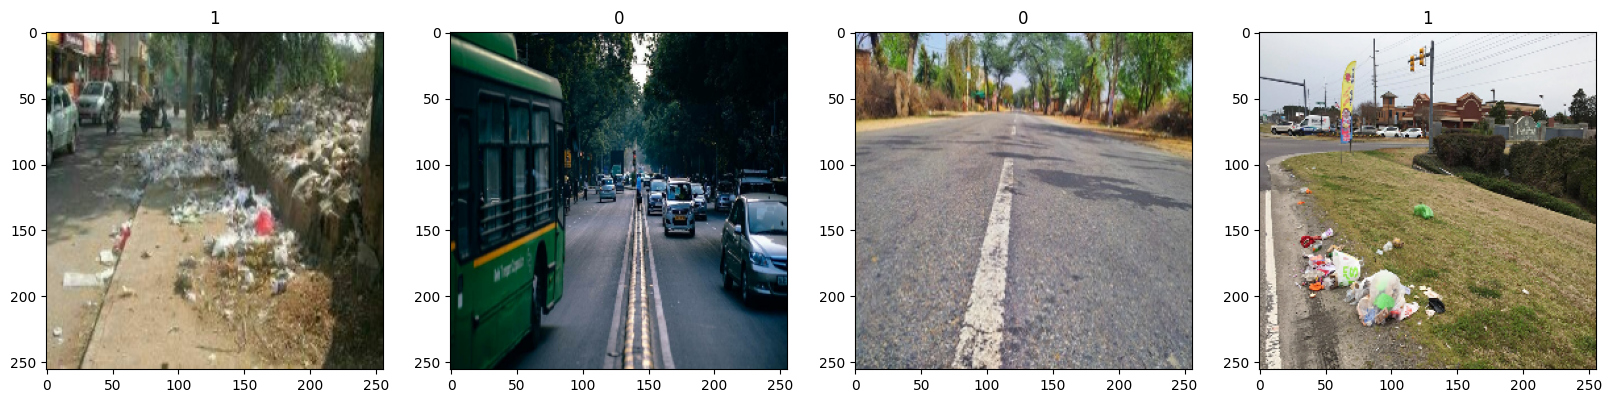

In [222]:
#this is one way too see wich classes belong 0 and 1
# 1 is littered
# 0 is clean
# we can see that the images have the same size
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])


# Preprocess Data
Divide all the data to get the smallest values

### This is for Testing wih greyScaler

This is for a test, we try creates a greyscaler images to check if the results is the same

In [223]:
# Function to convert the image to grayscale
def to_grayscale(image, label):
    # Convert image to grayscale using cv2
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label


In [224]:
# in this part we call the function to_grayScale, and save the result in the new tf.data.Dataset Object
data_greyscale = data.map(to_grayscale)

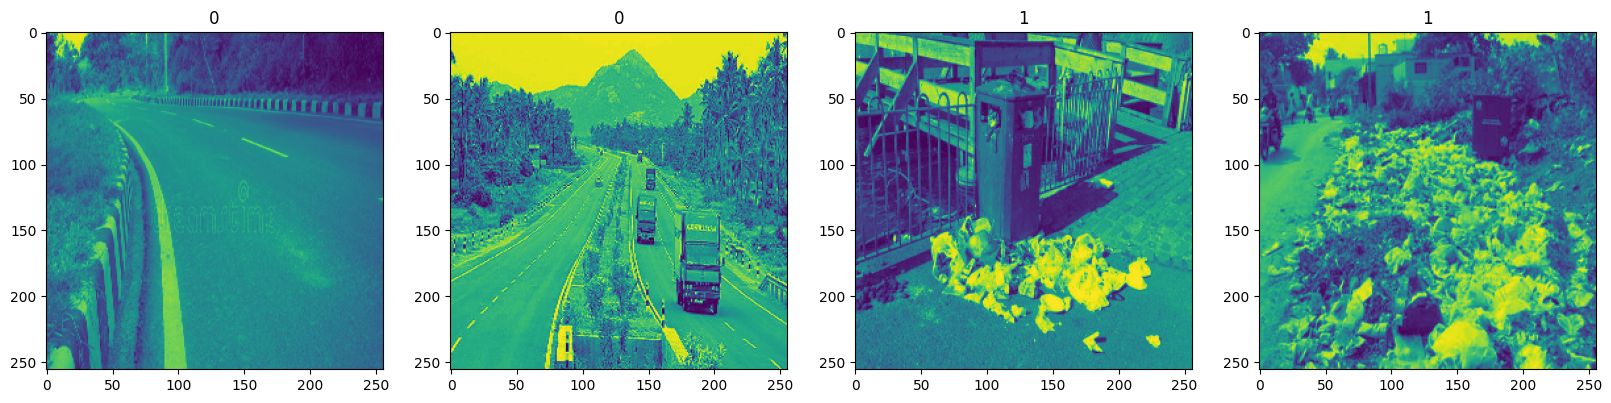

In [225]:
# show some fotos in gray scaler
data_iterator_gray = data_greyscale.as_numpy_iterator()
batch_grey = data_iterator_gray.next()
# plot the images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch_grey[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch_grey[1][idx])

In [226]:
# this is to use the images in grey_scale in the test
data_greyscale = data_greyscale.map(lambda x,y: (x/255, y))


Split the dataset, with the grey_scaler filtter, in train, validation and test

In [227]:
tam_data_grey = len(data_greyscale) #== 7
train_size_grey = int(tam_data_grey*0.7) #4 batch for train
val_size_grey = int(tam_data_grey*0.2)+1 #1 batch for validation
test_size_grey = int(tam_data_grey*0.1)+1 #1 batch for testing

In [228]:
#this will take the batches for each step of the model
train_grey = data_greyscale.take(train_size_grey)
val_grey = data_greyscale.skip(train_size_grey).take(val_size_grey)
test_grey = data_greyscale.skip(train_size_grey+val_size_grey).take(test_size_grey)


### Using data_argumentation

ImageDataGenerator allows you to apply data augmentation transformations in real time during model training.

In [81]:
# get a copy of the data
data_argumentation_test = data

In [82]:
tam_data_arg = len(data_argumentation_test) #== 7
train_size_arg = int(tam_data_arg*0.7) #4 batch for train
val_size_arg = int(tam_data_arg*0.2)+1 #1 batch for validation
test_size_arg = int(tam_data_arg*0.1)+1 #1 batch for testing

In [83]:
#this will take the batches for each step of the model
train_arg = data_argumentation_test.take(train_size_arg)
val_arg = data_argumentation_test.skip(train_size_arg).take(val_size_arg)
test_arg = data_argumentation_test.skip(train_size_arg+val_size_arg).take(test_size_arg)

In [84]:
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [85]:
type(train_arg)

tensorflow.python.data.ops.take_op._TakeDataset

This is important since, as we have a small dataset, we can increase the data in trino, using this technique, which changes the data with rotation, horizontal/vertical displacement, shear, zoom and horizontal flip. The random_transform function is then used to apply these transformations to each image in the dataset.

In [88]:
# Aplicar aumento de dados
def apply_augmentation(x, dummy_label):
    def augmentation_func(image):
        return data_augmentation.random_transform(image)

    augmented_image = tf.numpy_function(
        augmentation_func, [x], tf.float32
    )
    return augmented_image, dummy_label


In [89]:
train_data_augmented = train_arg.map(lambda x: apply_augmentation(x, 0))

TypeError: ignored

### Normalize the images pixels for the Normal train

Firstly, let's normalize the pixel size of the image. This ensures that all input values to the neural network are on the same scale

In [214]:
# scale data so we can read faster from the disk all the data
# all the images are between 0 and 1
data = data.map(lambda x,y: (x/255, y))

#data.as_numpy_iterator().next()[0].max()

Split the data in train, validation and test

In [215]:
tam_data = len(data) #== 7
train_size = int(tam_data*0.7) #4 batch for train
val_size = int(tam_data*0.2)+1 #1 batch for validation
test_size = int(tam_data*0.1)+1 #1 batch for testing

In [216]:
#this will take the batches for each step of the model
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# CNN - Create the Model


## Create CNN

In this cell we will define a callback that allows us to interrupt training whenever the "val_accuracy" value does not improve during two epochs.This allows you to finish the trine when you realize that it is no longer necessary to train

In [196]:
# import
from sklearn.metrics import classification_report

In [236]:
#CallBacks
# will stop training whenever "val_accuracy" does not improve in 2 epochs

callback_list = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
    ),

we create a function to create the convolutional layer and return a model of that layer. In this layer we define a "conv2d" layer with 16 filters, with a filter size of 3x3 and a step of 1. as activation we use the "relu" function,
In the last layer, since it is a binary classification problem, we use the sigmoid function.

In [231]:
def create_conv2d(canal):
  model = Sequential()

  #this one have 16 filters and the filter have 3x3 pixels
  # and move one pixel each time

  #with relu activation any output below 0 is converted to 0 and preseved the positive value
  model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,canal)))
  model.add(MaxPooling2D())

  model.add(Conv2D(32, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(15, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))

  #sigmoid reshape the output to a better result
  #have one single layer at final
  # convert the output to 0 or 1
  # 1 - littered
  # 0 - clean
  model.add(Dense(1, activation='sigmoid'))
  return model

In this case, we create a function to compile the model. We define 'adam' as an optimizer, 'binary_crossentropy' as a loss function and we will follow two metrics, such as 'accuracy and mse (mean square error)'.

In [199]:

def define_metrics(model):
  #adam - optmizer
  model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy', 'mse'])
  #to see all the layers
  model.summary()
  return model

# Test with normal images

### Train

In [232]:
# define the model and pass the number of channels, in this case they are 3
#Call the functions and show the model summary
# this summary is importan because we see how the convulational layer is behaving
model = create_conv2d(3)
model = define_metrics(model)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 60, 60, 15)        4335      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 30, 30, 15)       

train the model

In [233]:
history = model.fit(train, epochs=50, validation_data=val, validation_batch_size=8, callbacks=callback_list)

Epoch 1/50
4/4 [==============================] - 7s 843ms/step - loss: 1.0992 - accuracy: 0.5156 - mse: 0.3157 - val_loss: 0.7803 - val_accuracy: 0.5156 - val_mse: 0.2893
Epoch 2/50
4/4 [==============================] - 10s 1s/step - loss: 0.7243 - accuracy: 0.5156 - mse: 0.2641 - val_loss: 0.6639 - val_accuracy: 0.7344 - val_mse: 0.2354
Epoch 3/50
4/4 [==============================] - 5s 804ms/step - loss: 0.6441 - accuracy: 0.6250 - mse: 0.2260 - val_loss: 0.7083 - val_accuracy: 0.4531 - val_mse: 0.2585
Epoch 4/50
4/4 [==============================] - 8s 2s/step - loss: 0.6420 - accuracy: 0.5703 - mse: 0.2267 - val_loss: 0.5757 - val_accuracy: 0.8438 - val_mse: 0.1925
Epoch 5/50
4/4 [==============================] - 8s 2s/step - loss: 0.5874 - accuracy: 0.7578 - mse: 0.1988 - val_loss: 0.5578 - val_accuracy: 0.6094 - val_mse: 0.1907
Epoch 6/50
4/4 [==============================] - 5s 925ms/step - loss: 0.5947 - accuracy: 0.6094 - mse: 0.2077 - val_loss: 0.5144 - val_accuracy: 0

In [104]:
# see all the values
# loss, accuracy, val_loss,val_accuracy
history.history

{'loss': [0.33513879776000977,
  0.24455660581588745,
  0.2535557448863983,
  0.2041897177696228,
  0.1588546484708786,
  0.14238816499710083,
  0.1009381115436554,
  0.09621995687484741,
  0.06220518797636032,
  0.04441704973578453,
  0.02810191735625267,
  0.02636854350566864,
  0.01965515874326229,
  0.012066319584846497,
  0.006117241457104683,
  0.0088941790163517,
  0.008321678265929222],
 'accuracy': [0.8515625,
  0.90625,
  0.875,
  0.953125,
  0.9609375,
  0.953125,
  0.9453125,
  0.96875,
  0.9921875,
  0.984375,
  0.9921875,
  0.9921875,
  0.9921875,
  1.0,
  1.0,
  1.0,
  1.0],
 'mse': [0.10013598948717117,
  0.07210870832204819,
  0.07515200972557068,
  0.05684700608253479,
  0.042213257402181625,
  0.03872814029455185,
  0.0288534015417099,
  0.026537088677287102,
  0.013677448965609074,
  0.009542090818285942,
  0.005527847912162542,
  0.006242344155907631,
  0.0032954025082290173,
  0.0009377277456223965,
  0.00031432343530468643,
  0.0016305699246004224,
  0.0006470358

## Show Results

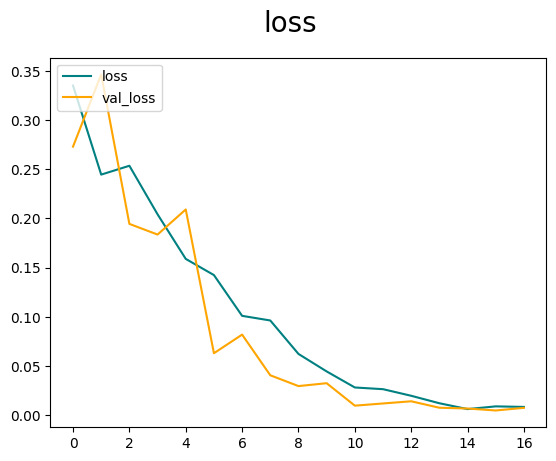

In [105]:
#loss graph
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

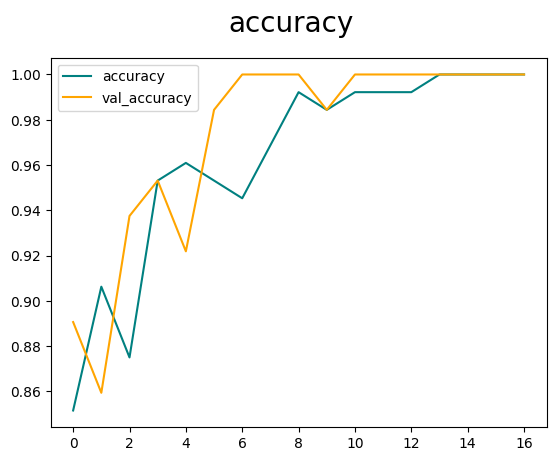

In [106]:
#accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

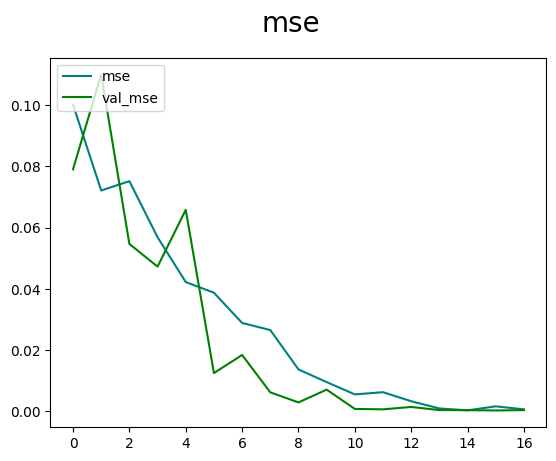

In [107]:
#mse
fig = plt.figure()
plt.plot(history.history['mse'], color='teal', label='mse')
plt.plot(history.history['val_mse'], color='green', label='val_mse')
fig.suptitle('mse', fontsize=20)
plt.legend(loc='upper left')
plt.show()

##Evaluate Performance


In [109]:
# Evaluate the model with the test data, for get the values of accuracy, loss and mse
loss, accuracy, mse = model.evaluate(test)

1/1 [==============================] - 2s 2s/step - loss: 0.0025 - accuracy: 1.0000 - mse: 2.1724e-05


In [122]:
# Do the Predictions with the test Data
y_pred = model.predict(test)

1/1 [==============================] - 2s 2s/step


In [123]:
# Arredondar as previsoes para 0 ou 1, de acordo com os nosso targets
y_predictions_classifier =[]
for d in y_pred:
  if d > 0.5:
    y_predictions_classifier.append(1)
  else:
    y_predictions_classifier.append(0)
# print preditions
y_predictions_classifier

[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1]

In [124]:
# Get a list with the values of the data test targets
labels_list = []
for batch in test.as_numpy_iterator():
    X, y = batch
    labels_list.extend(y.tolist())

# print the target list of test data
print(labels_list)


[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]


In [127]:
# Mostrar todas as metricas de acordo com as previsoes efetuadas pelo modelo
report = classification_report(labels_list, y_pred=y_predictions_classifier, digits= 4, target_names=['clean','littered'])
print(report)

              precision    recall  f1-score   support

       clean     0.2500    0.1250    0.1667         8
    littered     0.3636    0.5714    0.4444         7

    accuracy                         0.3333        15
   macro avg     0.3068    0.3482    0.3056        15
weighted avg     0.3030    0.3333    0.2963        15



In [128]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X,y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 71ms/step


In [129]:
# print the metrics
# Obter os resultados finais das métricas
precision_result = pre.result().numpy()
recall_result = re.result().numpy()
accuracy_result = acc.result().numpy()
print("Precision:", precision_result)
print("Recall:", recall_result)
print("Binary Accuracy:", accuracy_result)

Precision: 1.0
Recall: 1.0
Binary Accuracy: 1.0


In [140]:
#upload a Littered road
files.upload()

Saving clean.jpeg to clean.jpeg


{'clean.jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\xff\xdb\x00C\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\xff\xc0\x00\x11\x08\x01\xaa\x02\x7f\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x

In [141]:
def show_image(name):
  #img = cv2.imread('2749C52800000578-3025774-image-a-1_1428172476891-24412522.jpg')
  img = cv2.imread(name)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()
  return img

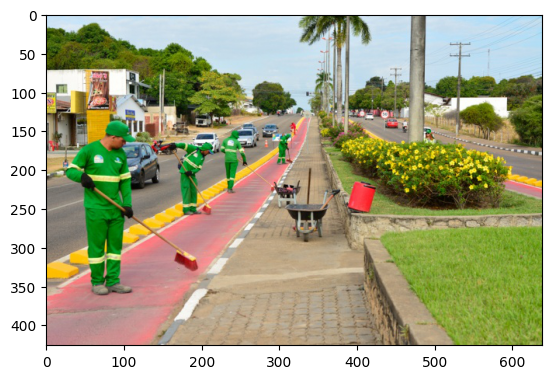

In [142]:
# teste for the clean image
# chose one image at time for the test
img = show_image('clean.jpeg')

In [ ]:
# teste for the dirty image
img = show_image('dirty.jpeg')

In [143]:
# resize the image
resize = tf.image.resize(img, (256,256))

In [144]:
#predict
np.expand_dims(resize, 0) #put in a list

yhat = model.predict(np.expand_dims(resize/255,0))

if yhat > 0.5:
  print('The road is dirty')
else:
  print('the road is clean')

1/1 [==============================] - 0s 18ms/step
the road is clean


# Teste the model with the grey_scaler

### Train

Call the model creatin and start the training

In [ ]:
# define the model and pass the number of channels, in this case they is 1 because this is a greyscale image
 # Call the functions and show the model summary
# this summary is importan because we see how the convulational layer is behaving
model = create_conv2d(1)
model = define_metrics(model)

In [235]:
history = model.fit(train_grey, epochs=50, validation_data=val_grey, validation_batch_size=16, callbacks=callback_list)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 60, 60, 15)        4335      
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 30, 30, 15)       

In [237]:
# see all the values
# loss, accuracy, val_loss,val_accuracy
history.history

{'loss': [0.9803961515426636,
  0.6483091711997986,
  0.6519538164138794,
  0.6148231625556946,
  0.5379931926727295,
  0.542555570602417,
  0.5221213102340698,
  0.5088924765586853,
  0.42657503485679626,
  0.46559837460517883,
  0.4377399981021881,
  0.3447381854057312,
  0.3177017867565155,
  0.2719198763370514,
  0.21729229390621185,
  0.21472075581550598,
  0.14591258764266968,
  0.15976166725158691,
  0.14276455342769623,
  0.08908994495868683,
  0.07127150893211365,
  0.0435611866414547,
  0.03845202177762985,
  0.02800101786851883,
  0.022116564214229584,
  0.012700224295258522],
 'accuracy': [0.5078125,
  0.6484375,
  0.6328125,
  0.75,
  0.7890625,
  0.7578125,
  0.7421875,
  0.7265625,
  0.828125,
  0.765625,
  0.796875,
  0.8515625,
  0.84375,
  0.890625,
  0.953125,
  0.9296875,
  0.96875,
  0.953125,
  0.9609375,
  0.9921875,
  0.96875,
  0.9921875,
  1.0,
  1.0,
  0.9921875,
  1.0],
 'mse': [0.34520748257637024,
  0.22839856147766113,
  0.23012793064117432,
  0.211638212

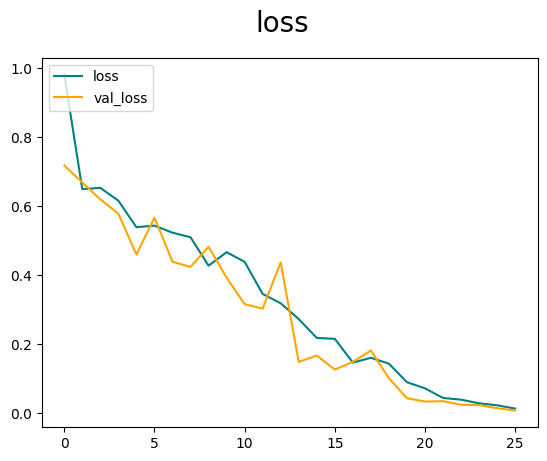

In [238]:
#loss graph
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

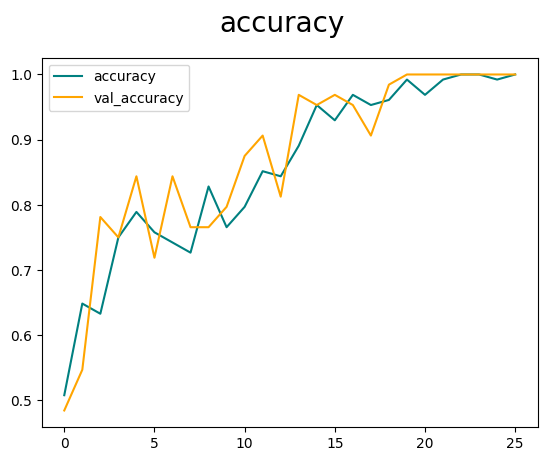

In [239]:
#accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

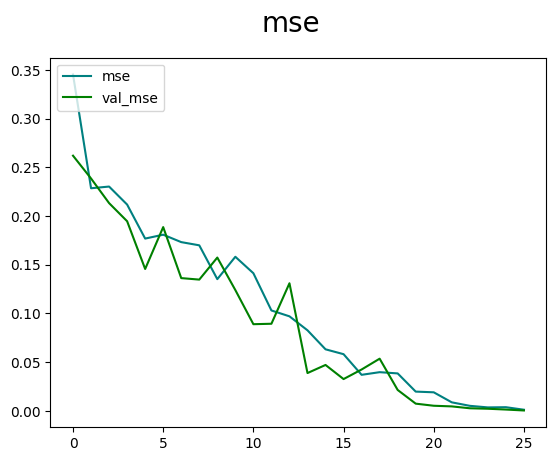

In [240]:
#mse
fig = plt.figure()
plt.plot(history.history['mse'], color='teal', label='mse')
plt.plot(history.history['val_mse'], color='green', label='val_mse')
fig.suptitle('mse', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### Evaluate Performance


In [242]:
# Evaluate the model with the test data, for get the values of accuracy, loss and mse
loss, accuracy, mse = model.evaluate(test_grey)

1/1 [==============================] - 5s 5s/step - loss: 0.0131 - accuracy: 1.0000 - mse: 9.2086e-04


In [243]:
# Do the Predictions with the test Data
y_pred_grey = model.predict(test_grey)

1/1 [==============================] - 2s 2s/step


In [244]:
# Arredondar as previsoes para 0 ou 1, de acordo com os nosso targets
y_predictions_classifier_grey =[]
for d in y_pred_grey:
  if d > 0.5:
    y_predictions_classifier_grey.append(1)
  else:
    y_predictions_classifier_grey.append(0)
# print preditions
y_predictions_classifier_grey

[0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0]

In [245]:
# Get a list with the values of the data test targets
labels_list = []
for batch in test_arg.as_numpy_iterator():
    X, y = batch
    labels_list.extend(y.tolist())

# print the target list of test data
print(labels_list)


[1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]


In [246]:
# Mostrar todas as metricas de acordo com as previsoes efetuadas pelo modelo
report = classification_report(labels_list, y_pred=y_predictions_classifier_grey, digits= 4, target_names=['clean','littered'])
print(report)

              precision    recall  f1-score   support

       clean     0.6000    0.7500    0.6667         8
    littered     0.6000    0.4286    0.5000         7

    accuracy                         0.6000        15
   macro avg     0.6000    0.5893    0.5833        15
weighted avg     0.6000    0.6000    0.5889        15



In [248]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test_grey.as_numpy_iterator():
  X,y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 83ms/step


In [249]:
# print the metrics
# Obter os resultados finais das métricas
precision_result = pre.result().numpy()
recall_result = re.result().numpy()
accuracy_result = acc.result().numpy()
print("Precision:", precision_result)
print("Recall:", recall_result)
print("Binary Accuracy:", accuracy_result)

Precision: 1.0
Recall: 1.0
Binary Accuracy: 1.0


In [250]:
#upload a Littered road
files.upload()
print()

Saving clean.jpeg to clean (1).jpeg



In [251]:
def show_image(name):
  #img = cv2.imread('2749C52800000578-3025774-image-a-1_1428172476891-24412522.jpg')

  img = cv2.imread(name)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
  plt.show()
  return img

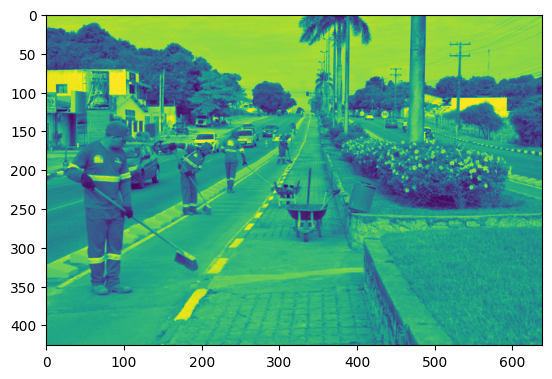

In [259]:
# teste for the clean image
# chose one image at time for the test
img = show_image('clean.jpeg')

In [ ]:
# teste for the dirty image
img = show_image('dirty.jpeg')

In [261]:
# resize the image
resize = tf.image.resize(img, (256,256))

In [262]:
# Normalizar e expandir as dimensões
input_data = np.expand_dims(resize, axis=0) / 255.0

# Fazer a previsão
yhat = model.predict(input_data)

if yhat > 0.5:
  print('The road is dirty')
else:
  print('the road is clean')

InternalError: ignored